Tutorial on *k-means clustering* from [Real Python](https://realpython.com/k-means-clustering-python/).

In [2]:
# %%html

# <style>
#     .container {width: 98%}
# <\style>

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['font.family'] = 'Liberation Sans'
mpl.rcParams['scatter.edgecolors'] = 'k'

#  k-means

Typical $k$-means algorithm:
* Specify n of clusters, $k$
* Randomly select $k$ centroids
* *Repeat*:
    * **Expectation**: assign each point to closest centroid
    * **Maximisation**: compute new centroid for each cluster
* *Until* the centroid positions do not change

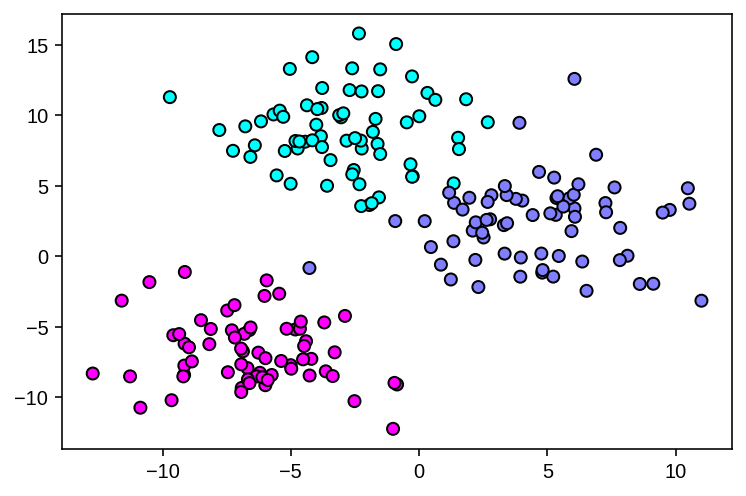

In [153]:
features, true_labels = make_blobs(n_samples=200, centers=3, cluster_std=2.75, random_state=42)

plt.figure()
plt.scatter(features[:,0], features[:,1], c=true_labels, ec='black', cmap='cool');

Need feature scaling to transform numerical feature to the same scale. Here **standardisation** is used, i.e. each numerical feature is scaled to have a mean of 0 and a std deviation of 1:

In [154]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

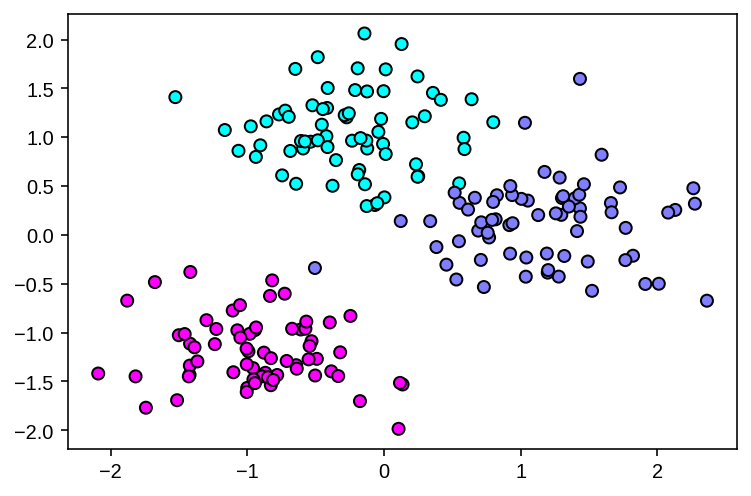

In [159]:
plt.figure()
plt.scatter(scaled_features[:,0], scaled_features[:,1], c=true_labels, ec='black', cmap='cool');

In [160]:
kmeans = KMeans(init='random', n_clusters=3, n_init=10, max_iter=300, random_state=42)

In [164]:
kmeans.fit(scaled_features, sample_weight=None)

KMeans(init='random', n_clusters=3, random_state=42)

In [165]:
print('The lowest SSE value was:', kmeans.inertia_)
print('\nThe final locations of the centroids: ', *kmeans.cluster_centers_)
print('\nThe number of iterations required to converge: ', kmeans.n_iter_)

The lowest SSE value was: 74.57960106819854

The final locations of the centroids:  [-0.25813925  1.05589975] [-0.91941183 -1.18551732] [1.19539276 0.13158148]

The number of iterations required to converge:  2


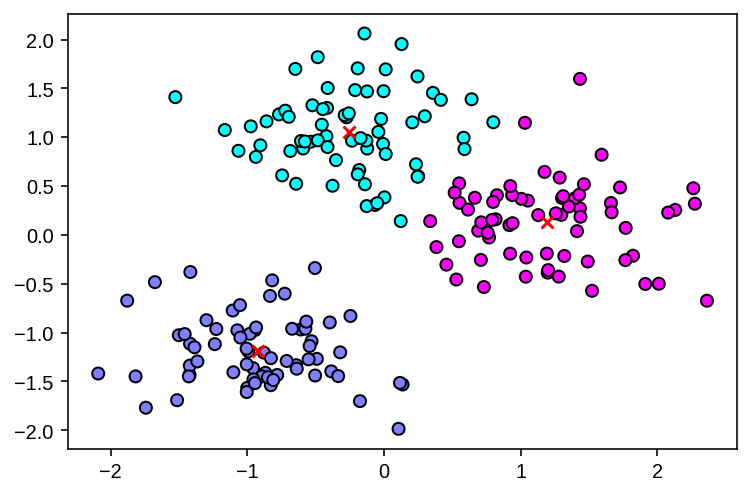

In [166]:
plt.figure()
plt.scatter(scaled_features[:,0], scaled_features[:,1], c=kmeans.labels_, ec='black', cmap='cool')
plt.scatter(*kmeans.cluster_centers_.T, marker='x', c='r')

## Choosing the appropriate number of clusters $k$ 

The **elbow method**: run several k-means, increment $k$ with each iteration, and record the SSE:

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

The sweet spot where the SSE vs $k$ curve starts to bend is known as the "elbow point", here placed at $x=3$:

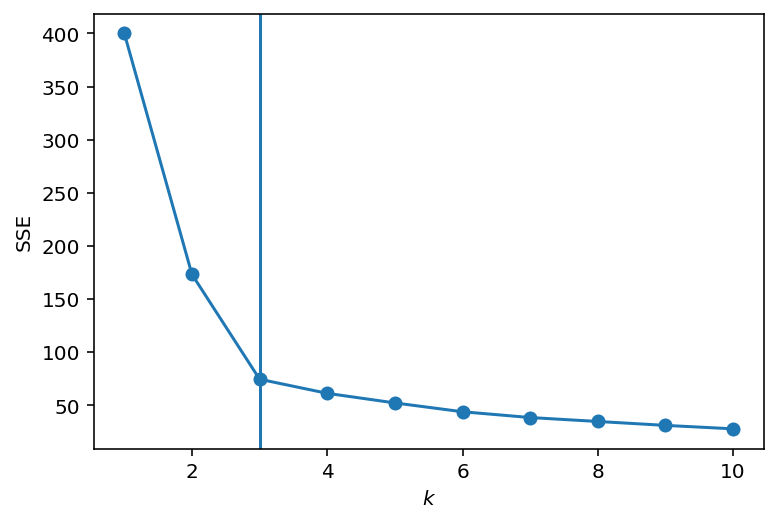

In [16]:
plt.figure()
plt.plot(range(1,11), sse, marker='o')
plt.xlabel('$k$')
plt.ylabel('SSE')
plt.axvline(3)

The **silhouette coefficient**: quantifies cluster cohesion and separation based on relative distances between points.

In [17]:
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient - otherwise error
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

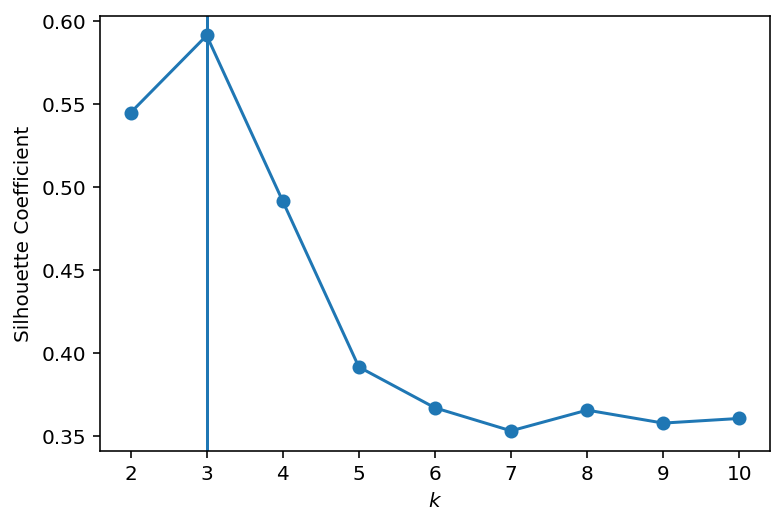

In [18]:
plt.figure()
plt.plot(range(2, 11), silhouette_coefficients, marker='o')
plt.xlabel("$k$")
plt.ylabel("Silhouette Coefficient")
plt.axvline(3)

## Advanced techniques to evaluate clustering performance

Could need these when comparing $k$-means with a density-based clustering method, e.g. DBSCAN (density-based spatial clustering of applications with noise):

In [19]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

In [20]:
features, true_labels = make_moons(n_samples=250, noise=0.05, random_state=42)
scaled_features = scaler.fit_transform(features)

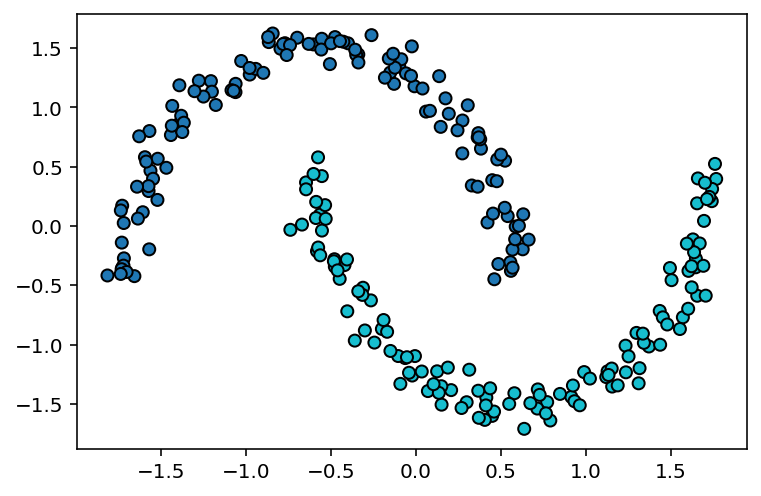

In [21]:
plt.figure()
plt.scatter(scaled_features[:,0], scaled_features[:,1], c=true_labels, cmap='tab10', ec='black')

In [22]:
# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=2)
dbscan = DBSCAN(eps=0.3)

# Fit the algorithms to the features
kmeans.fit(scaled_features)
dbscan.fit(scaled_features)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(scaled_features, kmeans.labels_).round(2)
dbscan_silhouette = silhouette_score(scaled_features, dbscan.labels_).round (2)

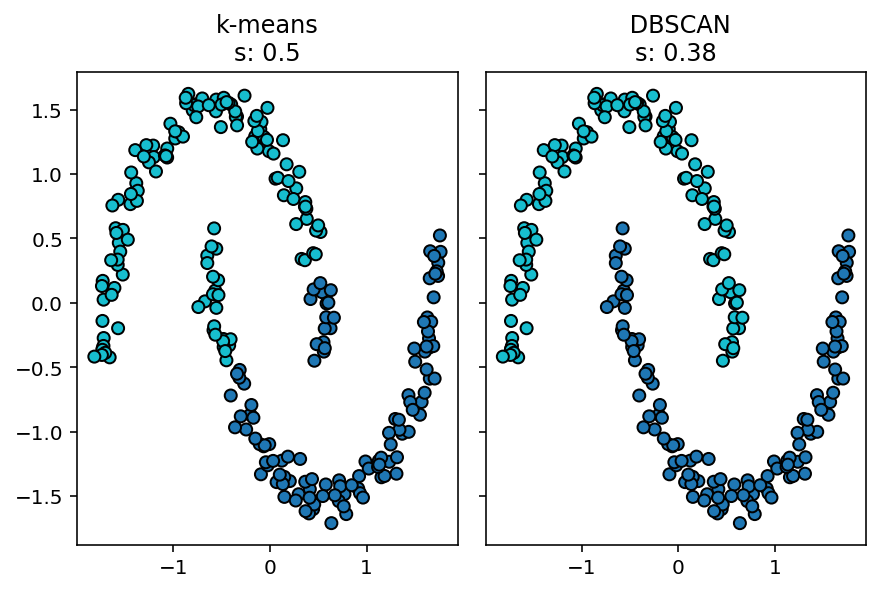

In [23]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True)

for i, l, n in zip([0,1], [kmeans.labels_, dbscan.labels_], f'k-means\ns: {kmeans_silhouette}, DBSCAN\ns: {dbscan_silhouette}'.split(',')):
    ax[i].scatter(scaled_features[:,0], scaled_features[:,1], c=l, cmap='tab10', ec='black')
    ax[i].set_title(n)

Value of silhouette gives misleading indication as DBSCAN gives better labelling.
Since we have the true labels we can use the adjusted rand index (ARI) as a better clustering metric:

In [24]:
ari_kmeans = adjusted_rand_score(true_labels, kmeans.labels_)
ari_dbscan = adjusted_rand_score(true_labels, dbscan.labels_)

print(f'ARI kmeans: {ari_kmeans}', f'\nARI dbscan: {ari_dbscan}')

ARI kmeans: 0.4712270735157155 
ARI dbscan: 1.0


# t-SNE

From [this Medium post](https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1) and [this notebook](https://nbviewer.jupyter.org/urls/gist.githubusercontent.com/AlexanderFabisch/1a0c648de22eff4a2a3e/raw/59d5bc5ed8f8bfd9ff1f7faa749d1b095aa97d5a/t-SNE.ipynb). Also, good resource [here](https://lvdmaaten.github.io/tsne/).

t-Distributed Stochastic Neighbour Embedding:

* unsupervised
* non-linear
* gives a feeling of how the data is arranged in ND space

Giving you an idea of whether using clustering algorithms makes any sense or not. Differences with respect to PCA: t-SNE preserves only small pairwise distances or local similarities, while PCA preserves large pairwise distances to maximise variance.

Algorithm:

1.  Measure gaussian density of points in the neighbourhood of each point: get (local) **pairwise similarities** $P_{ij}$ between points in ND space. I.e., two points in different regions of the ND space which have a similar neighbourhood will have a high $P_{ij}$ and be considered **similar**.

2. Repeat 1. using a Cauchy distribution obtaining $Q_{ij}$.

3. Measure the difference between $Q_{ij}$ and $P_{ij}$ using the [Kullback-Liebler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) (KL).

## The iris dataset

The iris dataset is a classic and very easy multi-class classification
dataset.

| Type | Value |
|---|---|
| Classes  |                        3 |
| Samples per class |              50 |
| Samples total |                 150 |
| Dimensionality |                  4 |
| Features |           real, positive |

Read more in the `User Guide <iris_dataset>`.

In [3]:
import numpy as np

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.datasets import load_iris

iris = load_iris() # data shape: 150, 4

In [6]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

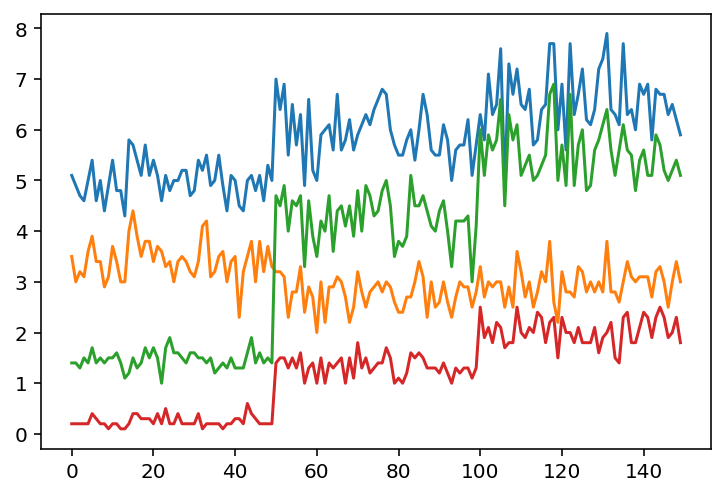

In [7]:
plt.figure()
[plt.plot(x) for x in iris.data.T];

In [8]:
X_tsne = TSNE(learning_rate=100).fit_transform(iris.data)
X_pca = PCA().fit_transform(iris.data)

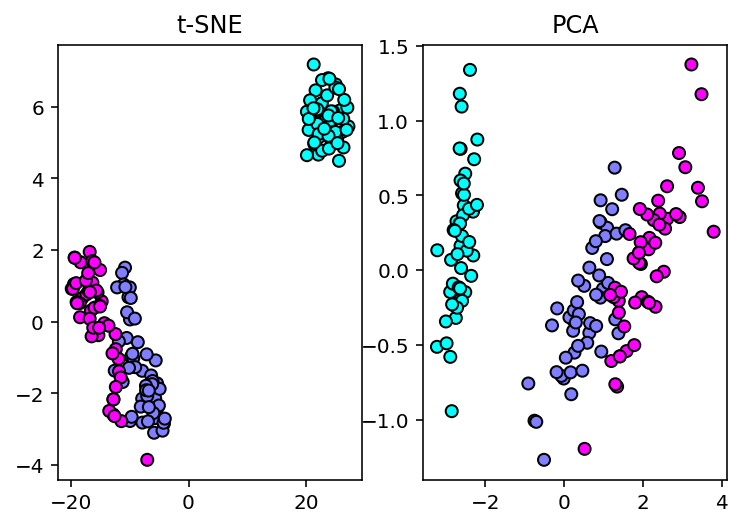

In [9]:
fig, ax = plt.subplots(1,2)

for a, X, name in zip(ax, [X_tsne, X_pca], 't-SNE,PCA'.split(',')):
    a.scatter(X[:,0], X[:,1], c=iris.target, ec='black', cmap='cool')
    a.set_title(name)

## The MNIST dataset

Have a look [here](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py) too

In [10]:
from sklearn.datasets import load_digits

# Load MNIST dataset
mnist = load_digits()
X, y = mnist.data / 255.0, mnist.target

# Create subset and reduce to first 50 dimensions
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
n_train_samples = 5000

X_pca = PCA(n_components=50).fit_transform(X)
X_train = X_pca[indices[:n_train_samples]]
y_train = y[indices[:n_train_samples]]

# PCA 

A fast and flexible unsupervised method for dimensionality reduction. [Source](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html).

In [2]:
rng = np.random.RandomState(1)
data = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T

plt.figure()
plt.scatter(data[:, 0], data[:, 1], c='dodgerblue')
plt.axis('equal')
plt.gca().set(xlabel='i', ylabel='Component 1');

NameError: name 'np' is not defined

By eye in the above it is clear there is a nearly linear relation between the $x$ and $y$ values. PCA attempts to learn about this relationship, which is quantified by finding a list of *principal axes* in the data. These axes are then used to describe the dataset.

In [105]:
from sklearn.decomposition import PCA

# init pca object
pca = PCA(n_components=2)

# fit the data
pca.fit(data)

# print some fit results
print(f'PCA components: {pca.components_}\n\nPCA explained variance: {pca.explained_variance_}')

PCA components: [[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]

PCA explained variance: [0.7625315 0.0184779]


We can plot these numbers as vectors on the input data to gain insight on their meaning. The *components* define the direction of the vector, while the *explained variance* defined the squared-length of the vector:

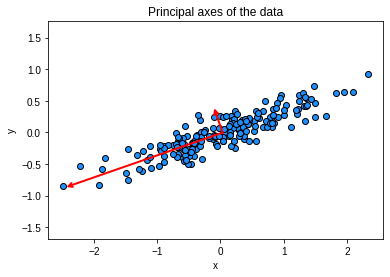

In [106]:
def draw_vector(v0, v1, ax):
    
    # parameters dictating the shape of the arrows to draw
    ap = dict(arrowstyle='->', lw=2, shrinkA=0, shrinkB=0, color='r')
        
    # add the arrow to the axes
    ax.annotate('', v1, v0, arrowprops=ap)
    
fig, ax = plt.subplots()

ax.scatter(data[:, 0], data[:, 1], c='dodgerblue')
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_+v, ax)

ax.set_title('Principal axes of the data')
ax.axis('equal')
ax.set(xlabel='x', ylabel='y');

These vectors represent the **principal axes** of the data. The length of a vector is an indication of how "important" that axis is in describing the distribution of the data. Specifically, the length of a vector is a measure of the variance of the data when projected onto that axis.

> Reminder: **variance** $S^2$
> $$ S^2 = \frac{\sum_i^n(x_i - \bar{x})}{n-1} $$
>
> where $x_i$ is observation $i$ on a total of $n$, and $\bar{x}$ is the mean value of all observations.

The projection of each data point onto the principal axes are the **principal components** of the data.

In [107]:
data_pca = pca.transform(data) # this is an affine transform --> translation + rotation + scaling

fig, ax = plt.subplots()

ax.scatter(data_pca[:, 0], data_pca[:, 1], c='dodgerblue')

ax.set(xlabel='Component 1', ylabel='Component 2', title='Principal Components')
ax.axis('equal');

## Dimensionality reduction by PCA

Namely, removing one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that still preserves the maximal data variance. We thus fit the data using only one component:

In [113]:
pca = PCA(n_components=1)
pca.fit(data)
data_pca = pca.transform(data)

print("original shape:   ", data.shape)
print("transformed shape:", data_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


[Text(0.5, 0, 'i'), Text(0, 0.5, 'Component 1')]

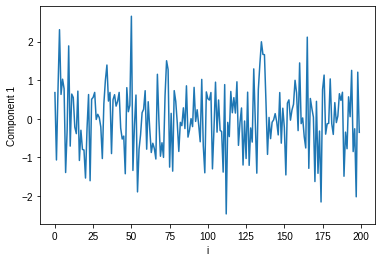

In [109]:
plt.figure()
plt.plot(data_pca)
plt.gca().set(xlabel='i', ylabel='Component 1')

In [110]:
data_reduced = pca.inverse_transform(data_pca)

fig, ax = plt.subplots()

ax.scatter(data[:, 0], data[:, 1], c='dodgerblue', alpha=.3, label='original')
ax.scatter(data_reduced[:, 0], data_reduced[:, 1], c='r', label='reduced')

ax.set(xlabel='x', ylabel='y')
ax.axis('equal')
ax.legend();

The information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance. This reduced-dimension dataset is often "good enough" to encode the most important relationship between the points.

### Example on a high-dimensional dataset

In [120]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.images.shape)

(1797, 8, 8)


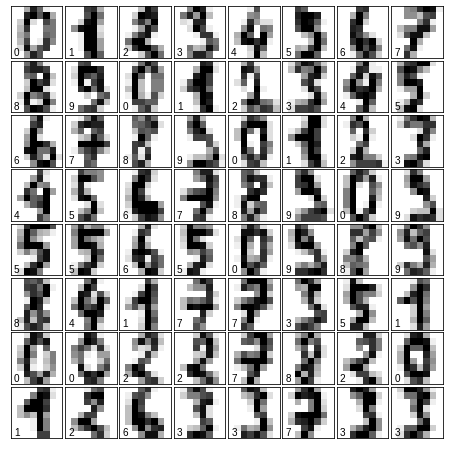

In [122]:
fig = plt.figure(figsize=(6, 6))  
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the first 64 digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Project from 64 to 2 dimensions:

In [123]:
pca = PCA(2)  
projected = pca.fit_transform(digits.data)

print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


Plot the first two principal components of each point:

In [126]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.8,
            cmap=plt.cm.get_cmap('Spectral', 10))

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar();

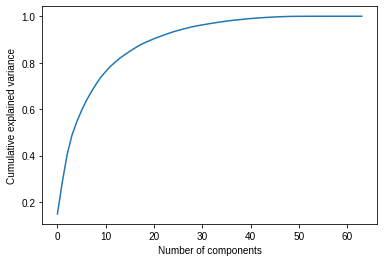

In [129]:
pca = PCA().fit(digits.data)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');